# FashionMNIST Image Classification with Neural Networks

## Introduction

In this notebook, we will explore the entire process of image classification using a neural network. We will use the FashionMNIST dataset, a dataset of 28x28 grayscale images of 10 fashion categories (like shirts, pants, shoes, etc.). We will preprocess the data, build a neural network model, train it, and evaluate the performance.

By the end of this notebook, you will have seen how to:
1. Load and preprocess data.
2. Build a neural network for image classification.
3. Train, validate, and evaluate the model.
4. Visualize the results.

### 1. Data Exploration

Before building a model, it's important to understand the dataset. This gives us a glimpse on the data we will be working with.

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Load the FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./datasets', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./datasets', train=False, download=True)

# Display basic info about the dataset
print(f"Training Set Size: {len(train_dataset)}")
print(f"Test Set Size: {len(test_dataset)}")

# Display the classes in the dataset
classes = train_dataset.classes
print(f"Classes: {classes}")

Training Set Size: 60000
Test Set Size: 10000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Comments:
- `train_dataset` and `test_dataset` are training and test data set of FashionMNIST dataset, containing 60,000 training images and 10,000 test images.
- Classes: These represent different categoeis of clothing in the dataset (Example: T-shirt/top, Trouser, Pullover, etc).

### 2. Data Processing and Preparation

Goals:
- Convert images to tensors (for neural network compatibility).
- Normalize them for efficient model training.
- Split the dataset into training and validation sets.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./datasets', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./datasets', train=False, download=True, transform=transform)

In [3]:
from torch.utils.data import DataLoader, random_split

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Split the training dataset into training and validation sets
val_split = 0.1
val_size = int(len(train_dataset) * val_split)
train_size = len(train_dataset) - val_size
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

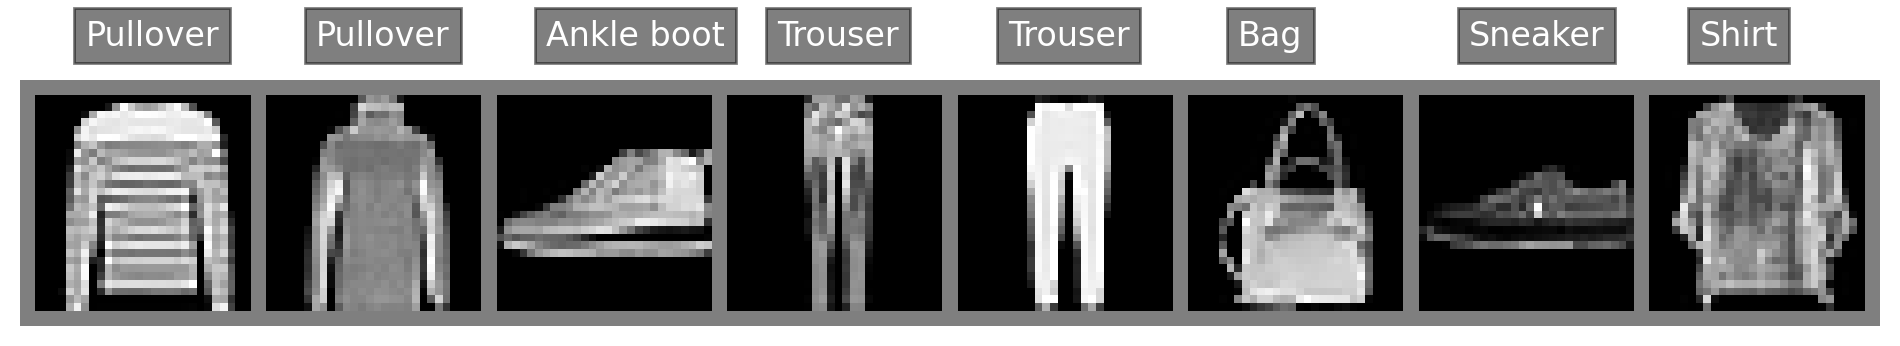

In [4]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import DataLoader

# Create DataLoader for the train dataset (already preprocessed)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)  # Get next batch

# Define a helper function to unnormalize and display the images
def imshow(img, labels):
    img = img / 2 + 0.5  # Unnormalize the image to [0, 1]
    npimg = img.numpy()  # Convert to numpy array for matplotlib
    fig, ax = plt.subplots(figsize=(12, 4), dpi=200)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  # Display the image
    
    # Annotate labels on top of the image
    for i in range(len(labels)):
        label = classes[labels[i]]  # Get class name from label
        ax.text(
            8 + i*30, -5, label, color='white', fontsize=12,  # Display label text at (x, y) position
            bbox=dict(facecolor='black', alpha=0.5)  # Add background box to make text readable
        )
    ax.axis('off')  # Turn off axis
    plt.show()

# Display a batch of images with corresponding labels
imshow(torchvision.utils.make_grid(images), labels)

### 3. Model Creation

Goals:
- Create a Neural Network: Convolutional Neural Network Model (CNN) for image classification

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class FMNISTClassifier(nn.Module):
    def __init__(self):
        super(FMNISTClassifier, self).__init__()
        
        # Define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # Convolutional layer extracting features from input image
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer: Reduces image size after convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # Fully connected layer to learn relationships in features extracted by convolution layers
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the output for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return x

### 4. Training the Model

Goals:
- Train the model on training data using cross-entropy loss and Adam Optimizer.

In [6]:
import torch.optim as optim

# Instantiate model and optimizer
model = FMNISTClassifier()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training Loop
epochs = 10
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    # Training step
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation step
    model.eval()  # Set model to evaluation mode
    
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Track losses and accuracies
    train_losses.append(running_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    val_accuracies.append(val_accuracy)

Epoch [1/10], Loss: 0.3601, Val Loss: 0.2677, Val Accuracy: 0.8987
Epoch [2/10], Loss: 0.2331, Val Loss: 0.1853, Val Accuracy: 0.9390
Epoch [3/10], Loss: 0.1891, Val Loss: 0.1572, Val Accuracy: 0.9418
Epoch [4/10], Loss: 0.1576, Val Loss: 0.1333, Val Accuracy: 0.9503
Epoch [5/10], Loss: 0.1320, Val Loss: 0.1036, Val Accuracy: 0.9622
Epoch [6/10], Loss: 0.1117, Val Loss: 0.0826, Val Accuracy: 0.9688
Epoch [7/10], Loss: 0.0947, Val Loss: 0.0614, Val Accuracy: 0.9797
Epoch [8/10], Loss: 0.0826, Val Loss: 0.0657, Val Accuracy: 0.9790
Epoch [9/10], Loss: 0.0720, Val Loss: 0.0498, Val Accuracy: 0.9835
Epoch [10/10], Loss: 0.0654, Val Loss: 0.0504, Val Accuracy: 0.9820


### 5. Testing and Evalution

Goal: Evaluate Model's performance using the ratio of predicted classification and the ground truth.

In [8]:
# Test the model
correct = 0
total = 0
model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 91.31%


### 6. Visualizations

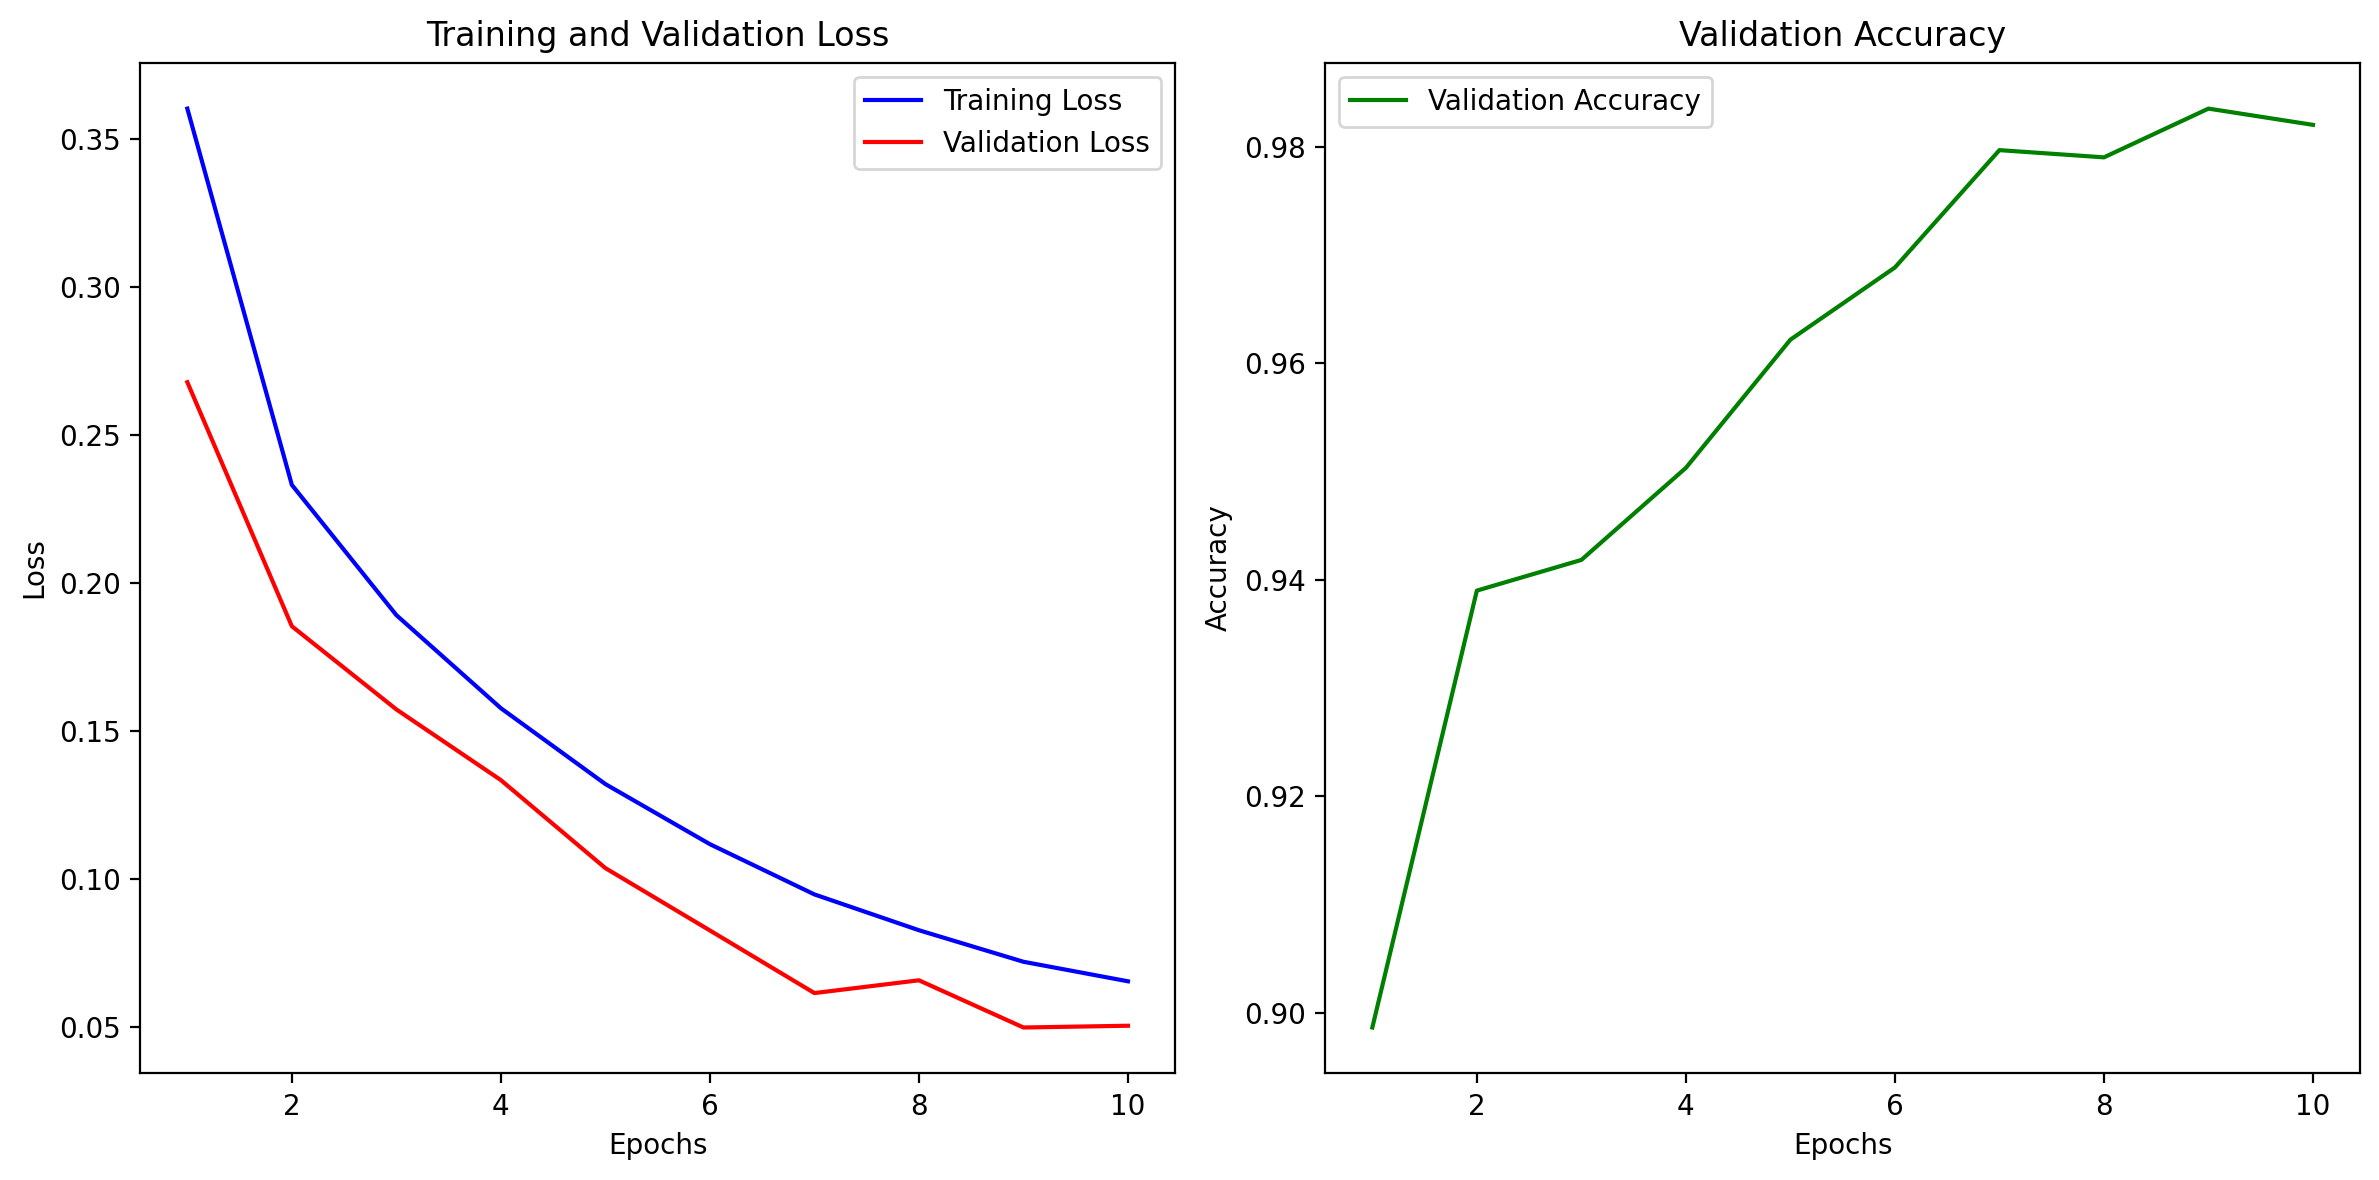

In [9]:
epochs = range(1, len(train_losses) + 1)

# Plot training loss
plt.figure(figsize=(12, 6), dpi=200)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", color='blue')
plt.plot(epochs, val_losses, label="Validation Loss", color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

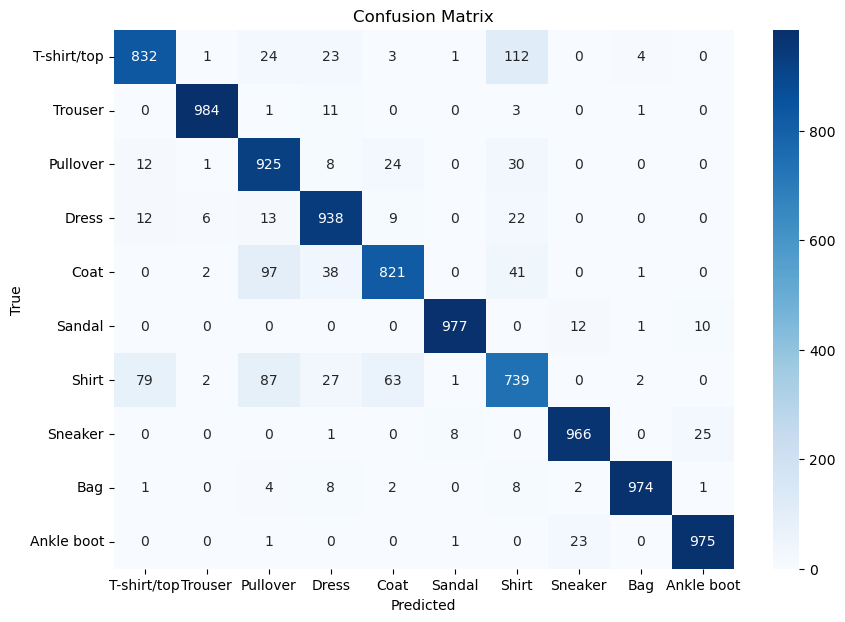

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Comments:
- The above confusion matrix shows us the True Positives (TP) and False Positives (FP) for each object in the dataset. The diagonal values shows the TPs, meaning that the model correctly identifies the objects whereas the off-diagonal boxes show the misidentified objects.
- Maximum 'confusion' occurs between T-shirt/top and Shirt. Moreover, the model seems to relate an image to Shirt more than anything (Pullover, Coat, T-shirt/top), which could be a consequence of a generalized model. This is better in most cases since we do not want to bias or overfit our model to a particular data set.

### 7. Conclusion

In this notebook, we successully built an image classification model using **FasionMINST** dataset. We learned to:
1. Preprocess data.
2. Build Convolutional neural network.
3. Train and evalute the model.

This project provides a strong foundation for understanding how neural networks can be used for image classification tasks.